# Predictions for volume

In [1]:
from enveco.las import *
from enveco.image import *
from enveco.tabular import *

In [2]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

# ANN

In [3]:
preprocessor = EnvecoPreprocessor('../enveco_data/enveco/AV.leaf.on.train.csv', 
                                  '../enveco_data/enveco/AV.leaf.on.val.csv',
                                  '../enveco_data/enveco/AV.leaf.on.test.csv')


Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features:
    * hmax: maximum height of the point cloud
    * hmean: mean height for vegetation pixels
    * hstd: standard deviation for vegetation pixels
    * cv: hstd / hmean
* point_features:
    * vege: proportion of vegetation points
    * ground: proportion of ground points
    * veg_ground_ratio: vege/ground
* intensity_features:
    * imax: maximum intensity for vegetation points
    * imean: mean intensity for vegetation points
    * imed: median intensity for vegetation points
* height_quantiles:
    * H where percentages of vegetation points (0%, 5%,...95%, 100%) were accumulated (e.g. h00, h05...h95, h100)
* point_proportions
    * Proportion of vegetation points having H greater or equal to corresponding percentile of H. H was divided to 10 equal distance fractions
 

array([[<AxesSubplot:title={'center':'v'}>]], dtype=object)

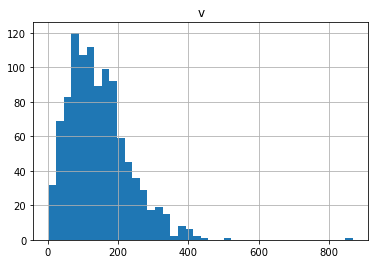

In [33]:
(trainval_tb.train.ys).hist(bins='auto')

array([[<AxesSubplot:title={'center':'v'}>]], dtype=object)

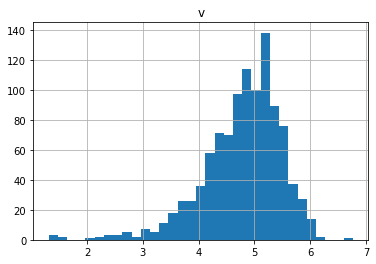

In [32]:
np.log1p(trainval_tb.train.ys).hist(bins='auto')

In [4]:
trainval_tb, test_tb = preprocessor.preprocess_lidar(target_col='v', path='../enveco_data/enveco/AV_las/', min_h=1.5,
                                                     height_features=True,
                                                     point_features=True, 
                                                     intensity_features=True, 
                                                     height_quantiles=True,
                                                     point_proportions=True, 
                                                     canopy_densities=True,
                                                     normalize=True)

Adding height based features
Adding point distribution based features
Adding intensity based features
Adding height quantiles
Adding point proportions
Adding canopy densities


In [35]:
trainval_tb.train.ys = np.log1p(trainval_tb.train.ys)

Put to dataloaders

In [37]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock())

In [38]:
dls.show_batch()

,hmax,hmean,hstd,cv,veg,veg_ground_ratio,imax,imean,imedian,h00,h05,h10,h15,h20,h25,h30,h35,h40,h45,h50,h55,h60,h65,h70,h75,h80,h85,h90,h95,p00,p05,p10,p15,p20,p25,p30,p35,p40,p45,p50,p55,p60,p65,p70,p75,p80,p85,p90,p95,d00,d10,d20,d30,d40,d50,d60,d70,d80,d90,v
0,27.441999,18.795242,4.694005,0.249744,0.764398,1239.377824,10.0,4.010274,4.0,5.045,8.98965,11.2470,13.31225,15.2078,16.783501,17.5798,18.10815,18.8858,19.687401,20.1985,20.474301,21.073601,21.382401,21.661899,21.994749,22.4952,22.941949,23.5508,24.566601,1.0,0.948630,0.897260,0.849315,0.797945,0.750000,0.698630,0.650685,0.599315,0.551370,0.500000,0.448630,0.400685,0.349315,0.301370,0.250000,0.202055,0.150685,0.102740,0.051370,0.020548,0.037671,5.821918e-02,4.794521e-02,0.071918,0.143836,0.181507,0.291096,0.123288,0.023973,425.799988
1,15.362000,11.207781,1.925773,0.171825,0.689655,515.555539,10.0,5.075000,5.0,1.704,8.56200,9.1912,9.61465,9.9162,10.167499,10.4740,10.68355,10.8518,11.079750,11.2450,11.467600,11.782800,11.969700,12.149400,12.498000,12.8130,13.210850,13.4659,13.724350,1.0,0.950000,0.900000,0.850000,0.800000,0.750000,0.700000,0.650000,0.600000,0.550000,0.500000,0.450000,0.400000,0.350000,0.300000,0.250000,0.206250,0.150000,0.100000,0.050000,0.006250,0.012500,1.289870e-09,-2.168321e-09,0.031250,0.150000,0.306250,0.256250,0.200000,0.037500,238.740005
2,16.802000,9.202346,2.963458,0.322033,0.708333,466.285707,10.0,4.566176,4.0,1.609,3.92375,4.4950,5.34900,6.7600,7.168750,7.8630,8.29225,9.1330,9.338250,9.8630,10.330750,10.517000,10.777250,11.085500,11.354750,11.7170,11.874000,12.5880,13.148000,1.0,0.948529,0.897059,0.845588,0.801471,0.750000,0.698529,0.647059,0.602941,0.551471,0.500000,0.448529,0.404412,0.352941,0.301471,0.250000,0.205882,0.154412,0.102941,0.051471,0.022059,0.088235,5.882353e-02,1.176471e-01,0.132353,0.213235,0.250000,0.095588,0.014706,0.007353,189.589996
3,13.847000,9.573439,2.284452,0.238624,0.414596,456.095490,9.0,4.082397,4.0,2.201,5.00100,6.2824,7.22680,8.1182,8.382000,8.5610,8.81140,9.2174,9.658000,9.9350,10.366900,10.485200,10.705500,10.961200,11.158000,11.3734,11.872200,12.2160,12.606100,1.0,0.947566,0.898876,0.850187,0.797753,0.749064,0.700375,0.647940,0.599251,0.550562,0.501873,0.449438,0.400749,0.352060,0.299625,0.250936,0.202247,0.149813,0.101124,0.052434,0.011236,0.014981,5.243446e-02,3.745318e-02,0.082397,0.198502,0.149813,0.269663,0.134831,0.048689,94.040001
4,20.601000,15.010804,3.466183,0.230913,0.470046,192.469562,10.0,3.960784,4.0,2.703,5.77570,11.4350,13.08155,13.4276,13.816000,14.3341,14.59730,14.9340,15.227400,15.5050,15.799100,16.131399,16.567551,16.805599,17.102501,17.2612,17.776400,18.3591,19.292700,1.0,0.941176,0.892157,0.843137,0.794118,0.745098,0.696078,0.647059,0.598039,0.549020,0.500000,0.450980,0.401961,0.352941,0.303922,0.254902,0.205882,0.156863,0.107843,0.058824,0.029412,0.029412,1.289870e-09,9.803924e-03,0.039216,0.098039,0.245098,0.274510,0.205882,0.068627,211.179993
5,12.608000,5.695797,2.564716,0.450282,0.408840,125.177574,7.0,4.297297,4.0,1.577,2.14060,2.4672,2.97185,3.4118,3.605250,4.0612,4.49210,4.6822,4.955950,5.4080,5.757750,6.386000,6.646500,6.776800,7.150500,7.6622,8.099400,9.0618,10.853249,1.0,0.945946,0.891892,0.851351,0.797297,0.743243,0.702703,0.648649,0.594595,0.554054,0.500000,0.445946,0.405405,0.351351,0.297297,0.256757,0.202703,0.148649,0.108108,0.054054,0.121622,0.148649,1.756757e-01,1.081081e-01,0.189189,0.108108,0.054054,0.027027,0.054054,0.013514,54.730000
6,20.885000,14.483569,3.222422,0.222488,0.666667,432.000000,12.0,4.972222,5.0,1.574,7.74265,10.4742,12.19540,12.6964,13.091250,13.4431,13.74870,14.0276,14.475800,15.0560,15.375700,15.635800,15.955000,16.234400,16.493999,16.9032,17.491301,17.9020,18.661249,1.0,0.944444,0.895833,0.847222,0.798611,0.750000,0.701389,0.645833,0.597222,0.548611,0.500000,0.451389,0.402778,0.354167,0.298611,0.250000,0.201389,0.152778,0.104167,0.055556,0.006944,0.020833,6.944443e-03,3.472222e-02,0.041667,0.152778,0.250000,0.298611,0.145833,0.041667,191.789993
7

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias.

In [7]:
learn = tabular_learner(dls, metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  y_range=(0,1000))
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 59'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 59              118        True      
________________________________________________________________
BatchNorm1d          64 x 59              118        True      
________________________________________________________________
Linear               64 x 200             11,800     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.002511886414140463)

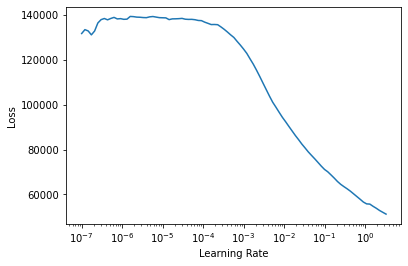

In [8]:
learn.lr_find()

1e-2 seems good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,131183.093750,129687.984375,360.122192,238.857513,350.767700,232.652969,350.767700,-13.250171,00:00
1,110779.601562,77123.726562,277.711609,184.197205,268.418701,178.033524,268.794708,-7.474389,00:00
2,79398.031250,19650.003906,140.178467,92.975883,104.522408,69.326363,122.612770,-1.159151,00:00
3,52190.117188,4003.524902,63.273411,41.967224,23.818674,15.798163,44.212036,0.560091,00:00
4,35060.878906,2155.762451,46.430187,30.795654,3.173673,2.104995,32.350437,0.763124,00:00
5,24389.953125,1972.215820,44.409637,29.455488,6.741696,4.471551,30.425455,0.783292,00:00
6,17432.812500,1797.685547,42.399120,28.121979,9.673519,6.416135,28.929289,0.802470,00:00
7,12766.463867,1624.467163,40.304680,26.732803,7.359661,4.881427,27.493824,0.821503,00:00
8,9445.467773,1433.348511,37.859589,25.111052,4.930694,3.270371,26.304293,0.842503,00:00
9,7107.251465,1362.385986,36.910511,24.481560,3.204717,2.125586,25.823681,0.850300,00:00


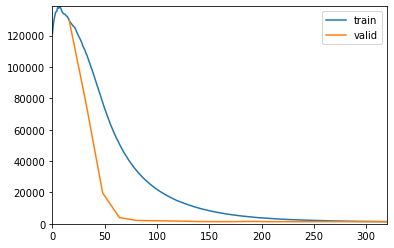

In [9]:
learn.fit_one_cycle(20, max_lr=1e-2, cbs=ShowGraphCallback())

See validation results

In [10]:
learn.validate()

(#7) [1398.5662841796875,37.39741134643555,24.80450439453125,8.705652236938477,5.7741804122924805,25.50416374206543,0.8463249201096072]

In [11]:
reg_interp = RegressionInterpretation.from_learner(learn, ds_idx=1)

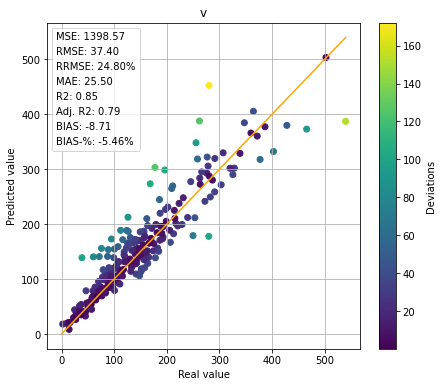

In [12]:
reg_interp.plot_results()
plt.show()

Evaluate test set.

In [13]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [14]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls)

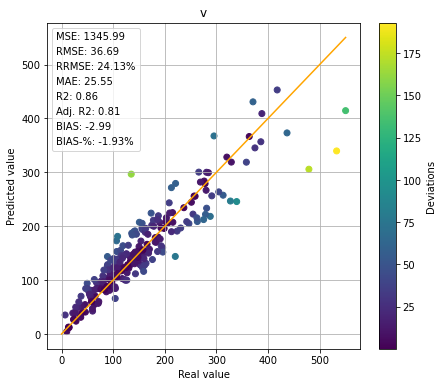

In [15]:
test_interp.plot_results()
plt.show()

# Ensemble of ANNs

Fit several models at once

In [16]:
ensemble = ANNEnsemble(dls, 
                       y_range=(0,1000), 
                       metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], n_models=10)

In [17]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,137585.234375,124838.429688,353.324829,234.349030,342.456635,227.140518,342.456604,-12.717300,00:00
1,114311.125000,70052.515625,264.674377,175.550034,247.872406,164.405823,250.157669,-6.697401,00:00
2,80912.109375,19719.371094,140.425674,93.139854,92.539772,61.378666,117.559395,-1.166773,00:00
3,53136.269531,4741.435547,68.858086,45.671360,35.590771,23.606218,49.922958,0.479009,00:00
4,35645.785156,2521.301758,50.212566,33.304386,5.945662,3.943567,35.928768,0.722958,00:00
5,24784.083984,2189.258301,46.789505,31.033978,9.901433,6.567303,33.249363,0.759443,00:00
6,17692.474609,2359.018799,48.569736,32.214748,-5.974292,-3.962556,33.567726,0.740790,00:00
7,12896.625000,2048.667725,45.262211,30.020973,-4.415758,-2.928831,31.029814,0.774892,00:00
8,9648.154297,1897.475708,43.560024,28.891968,-2.036064,-1.350456,29.943335,0.791505,00:00
9,7337.889160,1633.498657,40.416565,26.807013,-1.572141,-1.042751,27.919950,0.820510,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,170182.187500,151126.250000,388.749603,257.845154,373.506622,247.734985,374.635376,-15.605818,00:00
1,143986.406250,95598.953125,309.190796,205.076340,295.255829,195.833725,297.234772,-9.504454,00:00
2,103661.656250,26944.886719,164.148972,108.874748,121.319069,80.467049,143.894501,-1.960716,00:00
3,68443.351562,5137.208984,71.674324,47.539284,38.517254,25.547260,53.658993,0.435521,00:00
4,45791.871094,2492.334961,49.923290,33.112518,2.728450,1.809694,36.096264,0.726141,00:00
5,31751.224609,2410.783691,49.099731,32.566280,7.780261,5.160398,35.447590,0.735102,00:00
6,22533.800781,1797.263672,42.394150,28.118683,1.911367,1.267748,31.317081,0.802516,00:00
7,16362.871094,1915.606812,43.767647,29.029676,6.986870,4.634167,31.366426,0.789512,00:00
8,12037.196289,1903.680786,43.631195,28.939173,11.631792,7.714995,30.786861,0.790823,00:00
9,9010.577148,1699.678833,41.227158,27.344652,10.232220,6.786704,29.338287,0.813239,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,135935.890625,128617.867188,358.633331,237.869995,345.989166,229.483536,346.462677,-13.132587,00:00
1,114583.492188,75283.601562,274.378571,181.986511,260.279297,172.634918,262.216003,-7.272194,00:00
2,81899.187500,19206.462891,138.587372,91.920563,97.237404,64.494453,119.031517,-1.110414,00:00
3,53703.011719,3870.206055,62.210983,41.262550,23.007828,15.260354,46.486938,0.574740,00:00
4,36165.703125,2416.118408,49.154026,32.602291,5.746486,3.811460,35.721180,0.734516,00:00
5,25238.992188,2056.659668,45.350410,30.079472,1.209060,0.801931,32.284672,0.774013,00:00
6,18059.849609,2157.920654,46.453426,30.811068,10.912842,7.238138,32.468864,0.762887,00:00
7,13256.270508,1647.757324,40.592575,26.923756,4.621457,3.065264,29.233273,0.818944,00:00
8,9894.650391,1575.565308,39.693390,26.327354,6.526520,4.328832,28.296398,0.826876,00:00
9,7480.425781,1551.163086,39.384808,26.122681,2.813459,1.866077,27.668919,0.829558,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,106453.289062,99342.390625,315.186279,209.052948,302.474518,200.621643,303.531342,-9.915785,00:00
1,86756.070312,52772.421875,229.722504,152.367569,207.217377,137.440643,213.755280,-4.798657,00:00
2,60304.718750,13872.978516,117.783607,78.122093,72.504028,48.089600,98.562759,-0.524369,00:00
3,39566.511719,4075.239990,63.837605,42.341438,30.265089,20.073862,46.514523,0.552211,00:00
4,26836.964844,2229.683105,47.219521,31.319195,-0.497237,-0.329801,34.120247,0.755001,00:00
5,18804.556641,1922.287476,43.843899,29.080254,-0.054067,-0.035861,31.560516,0.788778,00:00
6,13529.176758,1832.510742,42.807831,28.393063,-0.669211,-0.443866,30.502689,0.798643,00:00
7,10102.589844,1577.178589,39.713711,26.340830,4.622552,3.065991,28.184347,0.826699,00:00
8,7622.623047,1502.087036,38.756767,25.706121,2.185841,1.449798,27.733711,0.834950,00:00
9,5859.037598,1639.639771,40.492462,26.857353,10.640569,7.057548,27.782761,0.819836,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,134775.531250,120496.562500,347.126160,230.237656,337.315796,223.730743,337.323944,-12.240214,00:00
1,111972.320312,68935.648438,262.556000,174.144989,243.017441,161.185684,245.634918,-6.574679,00:00
2,79273.820312,19751.791016,140.541077,93.216393,85.277206,56.561638,117.890350,-1.170335,00:00
3,52166.980469,3829.353271,61.881767,41.044193,24.126431,16.002289,44.516788,0.579229,00:00
4,35077.109375,2320.415039,48.170685,31.950071,5.709018,3.786609,33.933090,0.745032,00:00
5,24504.091797,1793.420288,42.348793,28.088596,-4.316025,-2.862681,29.683348,0.802938,00:00
6,17488.642578,1660.872559,40.753807,27.030695,0.912541,0.605259,28.671156,0.817503,00:00
7,12809.869141,1661.951660,40.767044,27.039474,10.781625,7.151106,29.204607,0.817384,00:00
8,9567.669922,1472.135864,38.368423,25.448545,5.864939,3.890026,26.948980,0.838241,00:00
9,7205.757812,1472.182373,38.369026,25.448946,7.683611,5.096293,26.788012,0.838236,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,167395.218750,143798.484375,379.207703,251.516312,369.965057,245.385956,369.965118,-14.800639,00:00
1,142560.453125,89222.710938,298.701691,198.119263,285.371796,189.277969,285.592255,-8.803830,00:00
2,104951.054688,28952.167969,170.153366,112.857269,127.036301,84.259102,147.046341,-2.181277,00:00
3,70353.335938,5552.966797,74.518234,49.425556,41.100277,27.260498,56.445175,0.389838,00:00
4,47305.222656,3350.499512,57.883503,38.392273,12.561344,8.331537,39.336311,0.631846,00:00
5,32858.062500,2482.015869,49.819836,33.043900,6.739300,4.469962,34.114113,0.727275,00:00
6,23400.523438,1994.949951,44.664864,29.624771,0.598347,0.396865,31.493547,0.780794,00:00
7,17013.335938,1807.318726,42.512569,28.197226,2.967225,1.968065,30.249554,0.801411,00:00
8,12536.642578,1678.592163,40.970627,27.174503,1.288746,0.854784,28.953600,0.815556,00:00
9,9389.893555,1994.465454,44.659439,29.621176,10.083156,6.687834,29.742130,0.780847,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,150312.468750,137214.031250,370.424133,245.690460,359.482269,238.433060,359.519470,-14.077137,00:00
1,127518.023438,84685.414062,291.007599,193.016022,276.837158,183.617203,279.763092,-8.305270,00:00
2,92504.476562,25149.375000,158.585541,105.184708,114.387009,75.869240,139.055832,-1.763424,00:00
3,61446.328125,6196.564453,78.718262,52.211304,34.498135,22.881508,56.567860,0.319119,00:00
4,41479.238281,2559.892334,50.595379,33.558292,4.185680,2.776228,35.591610,0.718718,00:00
5,28868.548828,2301.086670,47.969646,31.816730,9.564518,6.343838,32.627838,0.747156,00:00
6,20561.191406,2487.754395,49.877396,33.082077,11.281513,7.482666,32.824501,0.726644,00:00
7,15005.294922,1747.434692,41.802326,27.726143,5.264624,3.491856,28.273775,0.807991,00:00
8,11088.880859,1651.506714,40.638733,26.954369,4.104237,2.722208,27.055321,0.818532,00:00
9,8341.246094,1722.197144,41.499367,27.525198,6.623518,4.393167,27.115427,0.810764,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,147951.078125,126804.406250,356.096069,236.187103,343.908295,228.103333,344.137695,-12.933324,00:00
1,123888.070312,79434.773438,281.841736,186.936600,269.330719,178.638428,270.663147,-7.728327,00:00
2,88697.148438,23391.054688,152.941345,101.441101,117.073891,77.651360,134.694885,-1.570219,00:00
3,58455.632812,4380.795410,66.187584,43.900101,30.455576,20.200207,48.435543,0.518636,00:00
4,39299.218750,3217.355469,56.721741,37.621712,15.363552,10.190152,38.595810,0.646476,00:00
5,27390.470703,2117.962158,46.021320,30.524466,4.270146,2.832251,32.063637,0.767277,00:00
6,19504.923828,1846.350830,42.969185,28.500084,-1.876767,-1.244800,30.388863,0.797122,00:00
7,14173.151367,1649.882446,40.618744,26.941113,1.726549,1.145165,28.637405,0.818710,00:00
8,10504.024414,1761.869263,41.974625,27.840424,7.966575,5.283974,28.547348,0.806405,00:00
9,7912.998535,1481.924805,38.495777,25.533014,3.194665,2.118919,26.522940,0.837165,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,150721.062500,134315.187500,366.490356,243.081314,356.297546,236.320740,356.608948,-13.758609,00:00
1,127566.039062,84350.500000,290.431549,192.633942,277.652008,184.157684,279.522003,-8.268469,00:00
2,92245.671875,25345.365234,159.202286,105.593781,120.392616,79.852562,138.761932,-1.784960,00:00
3,61273.906250,5556.559082,74.542328,49.441536,42.205353,27.993456,56.841255,0.389443,00:00
4,41149.718750,2471.653320,49.715729,32.974850,8.218699,5.451200,35.815205,0.728414,00:00
5,28537.109375,1932.152466,43.956257,29.154778,6.111818,4.053773,32.023582,0.787694,00:00
6,20389.796875,2378.795898,48.772900,32.349499,-2.331276,-1.546261,34.116821,0.738617,00:00
7,14801.088867,1634.669189,40.431042,26.816612,6.073970,4.028670,29.590311,0.820382,00:00
8,10955.557617,1598.062256,39.975765,26.514643,2.320499,1.539113,28.912130,0.824404,00:00
9,8252.769531,1546.892578,39.330555,26.086697,6.468431,4.290303,28.696831,0.830027,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,98035.921875,97547.140625,312.325378,207.155426,298.474762,197.968750,300.157166,-9.718522,00:00
1,79932.625000,51984.933594,228.002045,151.226456,208.693085,138.419434,213.577789,-4.712127,00:00
2,55409.699219,12287.114258,110.847252,73.521431,69.983040,46.417507,92.612122,-0.350113,00:00
3,36177.453125,3830.197754,61.888592,41.048721,27.150393,18.007986,43.865570,0.579136,00:00
4,24423.984375,2332.631836,48.297329,32.034069,7.485770,4.965071,34.140350,0.743689,00:00
5,17144.095703,1784.674438,42.245407,28.020023,6.166956,4.090344,30.846056,0.803899,00:00
6,12324.971680,1576.931763,39.710602,26.338768,6.395033,4.241621,29.003443,0.826726,00:00
7,9053.440430,1526.756470,39.073730,25.916353,3.529590,2.341064,28.029234,0.832239,00:00
8,6794.905273,1480.884033,38.482258,25.524048,3.218854,2.134963,27.247526,0.837280,00:00
9,5244.641113,1406.842163,37.507893,24.877783,5.102065,3.384036,26.110725,0.845416,00:00


In [18]:
res = ensemble.validate()

In [19]:
res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,35.539040,23.571905,6.224453,4.128480,24.001022,0.861218
1,0,39.286575,26.057526,4.862722,3.225288,26.684046,0.830407
2,1,38.030018,25.224092,9.123233,6.051148,26.807213,0.841082
3,2,37.307167,24.744648,5.111227,3.390113,26.132444,0.847066
4,3,36.983768,24.530148,6.349353,4.211322,25.586052,0.849706
5,4,36.186180,24.001133,4.242014,2.813592,24.974922,0.856118
6,5,37.328262,24.758640,2.029610,1.346176,25.435707,0.846893
7,6,39.442398,26.160877,8.053983,5.341949,25.810518,0.829059
8,7,38.222332,25.351646,6.049642,4.012534,25.665775,0.839471
9,8,38.473331,25.518127,10.682971,7.085672,26.778625,0.837355


In [20]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

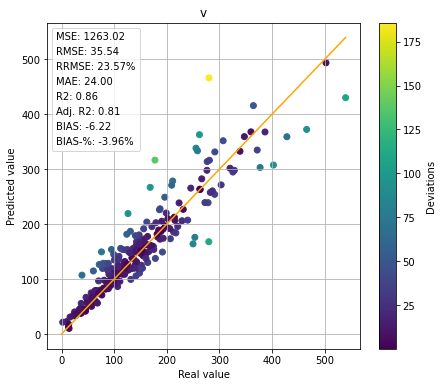

In [21]:
ens_int.plot_results()
plt.show()

In [22]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,34.774117,22.875654,0.761032,0.500634,23.618433,0.871501
1,0,37.059628,24.379147,0.649428,0.427217,25.705124,0.854054
2,1,36.072758,23.729948,3.448653,2.268647,25.154835,0.861724
3,2,35.804817,23.553688,1.097218,0.721789,25.334999,0.863770
4,3,37.561295,24.709160,-0.101909,-0.067040,25.375706,0.850076
5,4,37.320972,24.551067,-1.737842,-1.143215,25.188383,0.851989
6,5,37.877491,24.917166,-1.724563,-1.134479,26.369532,0.847542
7,6,35.545410,23.383039,1.089597,0.716776,23.921097,0.865737
8,7,40.107388,26.384071,1.555880,1.023514,27.067041,0.829062
9,8,36.961563,24.314636,3.525200,2.319002,26.225885,0.854826


In [23]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

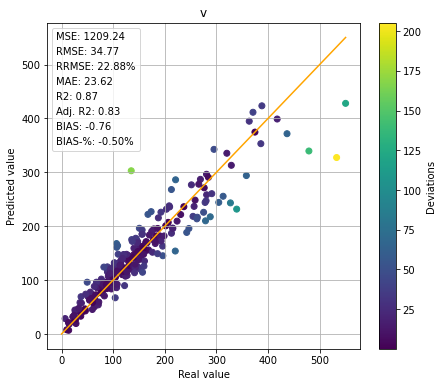

In [24]:
test_ens_interp.plot_results()
plt.show()

In [25]:
ensemble.predict(trainval_tb.decode_row(trainval_tb.valid.xs.iloc[0]))

(      hmax     hmean     hstd        cv       veg  veg_ground_ratio      imax  \
 0  2.96732  2.891253  2.43145  0.012076  1.906041          4.949219  1.453321   
 
       imean   imedian       h00  ...       d10       d20       d30       d40  \
 0  1.405186  1.232427 -0.684575  ... -0.780248 -0.780289 -0.541685 -0.751295   
 
         d50       d60       d70       d80       d90           v  
 0 -0.595009  0.858973  1.252316  0.614971  0.310631  387.535034  
 
 [1 rows x 60 columns],
 tensor([429.8660]),
 tensor([429.8660]))

In [26]:
model_res = [m.predict(trainval_tb.decode_row(trainval_tb.valid.xs.iloc[0])) for m in ensemble.models]

In [27]:
for res in model_res:
    print(res[-1])
sum([res[-1] for res in model_res]) / len(ensemble.models)

tensor([387.5350])
tensor([454.6207])
tensor([445.8243])
tensor([408.7952])
tensor([448.3897])
tensor([437.7622])
tensor([432.4256])
tensor([449.0938])
tensor([435.4982])
tensor([398.7152])


tensor([429.8660])

In [28]:
trainval_tb.valid.ys.iloc[0]

v    539.47998
Name: 0, dtype: float32

# Comparison: Random forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [30]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [31]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [32]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

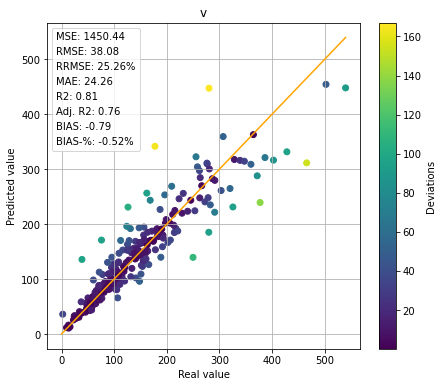

In [33]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys)
plt.show()

Test

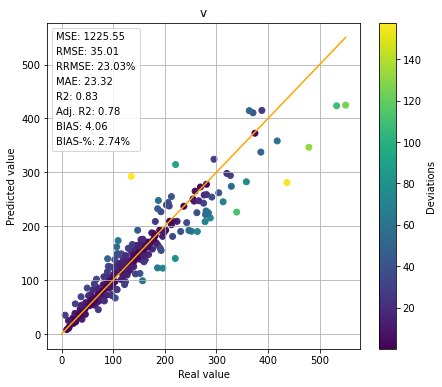

In [34]:
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()

## SHAP for RF

Todo comments and info.

In [35]:
import shap
shap.initjs()

In [36]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_tb.train.xs)

Get most influential features

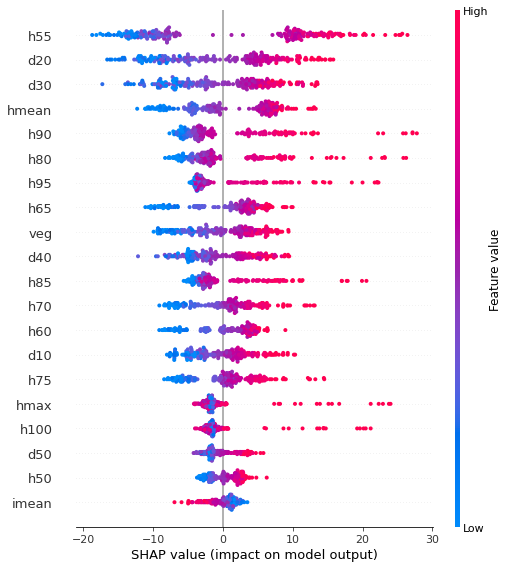

In [37]:
shap.summary_plot(shap_values, test_tb.train.xs)

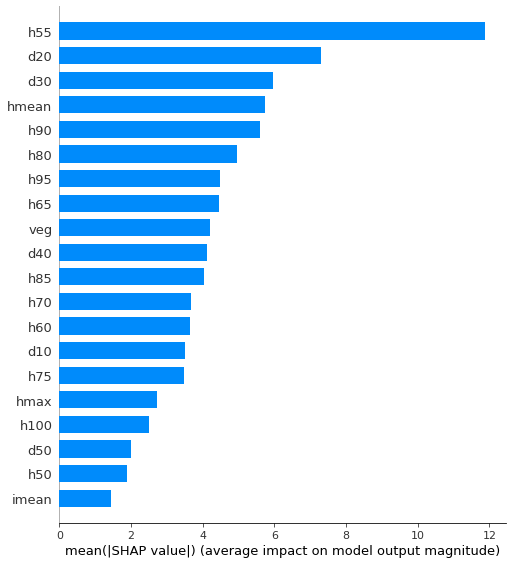

In [38]:
shap.summary_plot(shap_values, test_tb.train.xs, plot_type='bar')